### **Introduction**

This notebook applies Stochastic RNN (SRNN) to a simple synthetic problem:
- It generates a synthetic time series of a dynamical system with external trend and forcing
- It trains SRNN to emulate the dynamics based on the generated time series
- It shows how to use SRNN to make predictions and assess the model performance
- The main goal of this notebook is the demonstration of the pipeline and how-to points 
 

To run this notebook, additional packages are needed:

``` conda
pip install scikit-learn sdeint
```

Also, the code imports from other repository files, and therefore supposed to be run from the current directory. These imports are below.


In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
# useful on linux to avoid numpy multithreading

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle as pkl
import sklearn
import torch
torch.set_default_dtype(torch.float64)
# can be omitted or changed to the preferrred Tensors precision

# imports of the repository files, ensure that they work
try: 
    import srnn, srnn_utils
    # if the package was installed via pip command  
except ImportError:
    import sys, os
    sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), "src"))
    import srnn, srnn_utils
    # if the package is not installed into the environment, make sure the "path" variable below includes "src" folder containing srnn python files. Here -- "../src"

from L96_custom_generator import generate_datasets
# Note that this module has its own random generator inside

np.random.seed(1)
torch.manual_seed(2)
# fixing random generators for stable debugging

### **1. Generate synthetic data**

The generator is put into a separate file "L96_custom_generator.py" in the same folder, imported above. It's a stochastic Lorenz-96 system (SDE) with slow parameter trend and periodic forcing -- to show applicability of the approach to such cases. We generate 2 trajectories, and use one of them as a training data for the model, and the other will be used to assess the performance of the trained model.



Our training data, time, forcing arrays:

In [2]:
raw_training_data, raw_time, raw_forcing = generate_datasets(N=1000,ensemble_size=1)

print(raw_training_data.shape, raw_time.shape, raw_forcing.shape)

(1000, 2) (1000, 1) (1000, 2)


The data time series and 2-D trajectory plots:

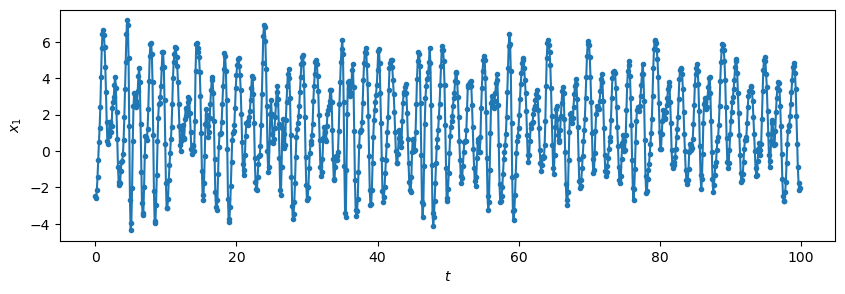

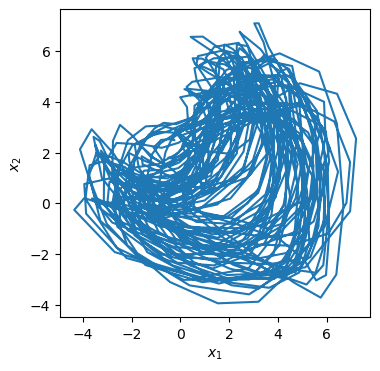

In [3]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,1,1)
ax.plot(raw_time[:,0], raw_training_data[:, 0],'.-')
ax.set_xlabel("$t$")
ax.set_ylabel("$x_1$")
plt.show()

# Plot the first two variables
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
ax.plot(raw_training_data[:1000, 0], raw_training_data[:1000, 1])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
plt.show()

Generate also the trajectory to assess the performance of the trained model:

In [4]:
raw_evaluation_data, _, _ = generate_datasets(N=1000,ensemble_size=1)

To make some impression about the system predictability and periodic forcing effects, let's plot an ensemble of trajectories

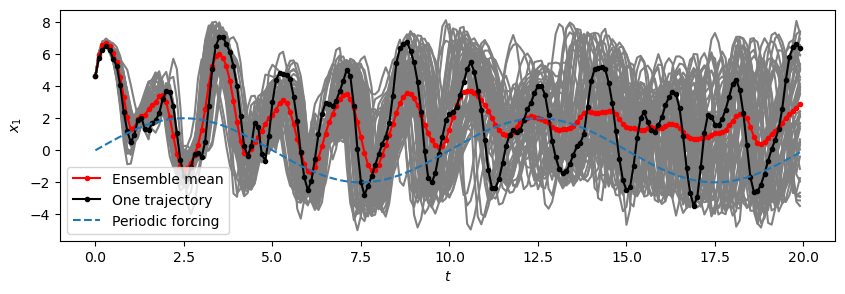

In [5]:
raw_ensemble_data1, raw_time1, raw_forcing1= generate_datasets(N=200,ensemble_size=50)
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,1,1)
ax.plot(raw_time1[:,0], raw_ensemble_data1[:,:, 0].T,'-',color='gray')
ax.plot(raw_time1[:,0], raw_ensemble_data1[:,:, 0].mean(axis=0),'.-r',label='Ensemble mean')
ax.plot(raw_time1[:,0], raw_ensemble_data1[0,:, 0],'.-k',label='One trajectory')
ax.plot(raw_time1[:,0], raw_forcing1[:, 0],'--',label='Periodic forcing')
ax.set_xlabel("$t$")
ax.set_ylabel("$x_1$")
ax.legend()
plt.show()

### **2. Normalize the data, prepare time series of inputs and targets**

2.1. Regularization in StochasticRNN class is set up for the inputs/targets with near-zero mean and near-unit variance. Therefore, we normalize all time series (it is possible to do after step 2.2 too)

In [6]:
data_scaler=sklearn.preprocessing.StandardScaler()
training_data=data_scaler.fit_transform(raw_training_data)

time_scaler=sklearn.preprocessing.StandardScaler()
time=time_scaler.fit_transform(raw_time)

forcing_scaler=sklearn.preprocessing.StandardScaler()
forcing=forcing_scaler.fit_transform(raw_forcing)

Switch to torch type from now on:

In [7]:
training_data=torch.tensor(training_data,dtype=torch.get_default_dtype()) 
time=torch.tensor(time,dtype=torch.get_default_dtype()) 
forcing=torch.tensor(forcing,dtype=torch.get_default_dtype())

2.2. We create the time-synchronized time series of input and target variables, simply by stacking time series. Here RNN uses the values of data, forcing and time to predict the data in the next moment.

In [8]:
input_ts=torch.cat([training_data,time,forcing],dim=-1)
target_ts=training_data

print(input_ts.size(),target_ts.size())

torch.Size([1000, 5]) torch.Size([1000, 2])


### **3. Train and optimize Stochastic RNN**

In this example we are going to optimize over the hyperparameter $m$ (number of neurons in the RNN cell), therefore we create a train function to iterate over $m$.

We will use simple cross-validation strategy to optimize $m$, by reserving the last 1/5 of the data for validation and early stopping. Note that in SRNN we use different training and validation losses, both of them are based on probabilistic Bayesian formulation of the SRNN model.

In [9]:
def single_train(input_ts,target_ts,options={'m': 2}):  
    '''
    Performs a single training and returns dictionary with the results.
    '''
    #Specify the changeable parameters 
    m=options['m'] 
    # number of neurons to use in the RNN cell
    
    lag=15 
    # the length of the RNN sequence 
    # (number of past values of input_ts involved in the prediction of the current value of the target_ts)
    
    init_length=15 
    # the number values at the start of time series which will not be used as a target 
    # (useful to keep the same training set and allow lag optimization <=init_length)
    
    dim_in, dim_out=input_ts.shape[-1],target_ts.shape[-1]
    nfolds=5 
    # in cross-validation setting, it means that the data will be splitted into "nfolds" sequential parts, 
    # and one of these parts will be used for validation, and others are used in loss minimization
    
    nfold=4 
    # number of the validation fold, could be 0, 1, ..., nfolds-1         
    
    # save to the hyperparametr dictionary H
    H={'m':m,'lag':lag,'init_length':init_length,'dim_in':dim_in,'dim_out':dim_out,'nfolds':nfolds,'nfold':nfold}

    #to create the list of torch input/target pairs for SRNN model
    # 2) cut and split into train/validation subsets using a custom torch Dataset class in srnn_utils
    training_data=srnn_utils.InputsAndTargetsFromTimeSeries(
          input_ts[None,:,:],target_ts[None,:,:],lag,init_length,nfold=nfold,nfolds=nfolds,mode='train')
    train_dataloader=torch.utils.data.DataLoader(training_data, batch_size=len(training_data), shuffle=False)
    test_data=srnn_utils.InputsAndTargetsFromTimeSeries(
          input_ts[None,:,:],target_ts[None,:,:],lag,init_length,nfold=nfold,nfolds=nfolds,mode='test')
    test_dataloader=torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=False)  
    inputs, targets = list(train_dataloader)[0] 
    test_inputs, test_targets = list(test_dataloader)[0]
    #this creates train/test inputs ~ [N,lag,dim_in] and targets ~ [N,1,dim_out]  -- N pairs
    #could be alternatively done in a more explicit way without Dataloaders

    # create the model class, note that it is the same for any lag
    model=srnn.StochasticRNN(dim_in=dim_in,dim_out=dim_out,m=m)
    # set to the training mode
    model.train() 
    # fit using custom training function, with early stopping based on validation loss
    # BFGS scipy wrapper is used inside (usually efficient for low-dimensional setting)
    # The other option is "model.fit_adam" or make another custom training function
    training_status=model.fit_bfgs(inputs, targets,test_inputs, test_targets,options={})
    #training_status['opt_metrics'] contains most of necessary values, but we can compute them explicitly
    with torch.no_grad():
        training_loss=model.total_training_loss(inputs,targets).item()
        validation_loss=model.total_validation_loss(test_inputs,test_targets).item()
        weights=deepcopy(model.state_dict()) 
    
    # if we don't want to save the whole model class, we ensure saving the weights an the hyperparameters H
    training_result={**H,**{'weights':weights,'training_loss':training_loss,'validation_loss':validation_loss}}
    return training_result

Loop few rounds over $m$ and save the results

In [10]:
# initiate a list to store results of multiple trainings
trained_rnn_parameters_list=[]
# file to backup the list
fname='trained_rnn_parameters_list.pkl3'
for n in range(10):
    for m in range(1,20):
        #train with m neurons
        trained_rnn_parameters=single_train(input_ts,target_ts,options={'m':m})
        # save the iteration number too
        trained_rnn_parameters['n']=n 
        trained_rnn_parameters_list.append(trained_rnn_parameters)                      

        #print something, because it may take large time without parallelization
        for key in ['n','m','training_loss','validation_loss']: print(key,'=',trained_rnn_parameters[key],end=', ')
        print('')
        

n = 0, m = 1, training_loss = 0.5570310991064854, validation_loss = 0.4391926966440213, 
n = 0, m = 2, training_loss = -0.21489598794678239, validation_loss = -0.40676410961667164, 
n = 0, m = 3, training_loss = -0.4864617975882217, validation_loss = -0.6877868715997104, 
n = 0, m = 4, training_loss = -0.6941939485668028, validation_loss = -0.8979043011064229, 
n = 0, m = 5, training_loss = -0.7777036333249949, validation_loss = -0.9569450473351615, 
n = 0, m = 6, training_loss = -0.7625680930918015, validation_loss = -0.9537099874520134, 
n = 0, m = 7, training_loss = -0.7326025635850649, validation_loss = -0.9807139121213886, 
n = 0, m = 8, training_loss = -0.7231396690569644, validation_loss = -0.9789717454434307, 
n = 0, m = 9, training_loss = -0.734718365238292, validation_loss = -0.9488502280288251, 
n = 0, m = 10, training_loss = -0.7073046051465308, validation_loss = -0.9688323691109044, 
n = 0, m = 11, training_loss = -0.7554676993784424, validation_loss = -1.0399354879211409,

### **4. Select the most optimal model**

We have a list of trained SRNN parameters. Let's plot validation loss and use it to choose the most optimal model.

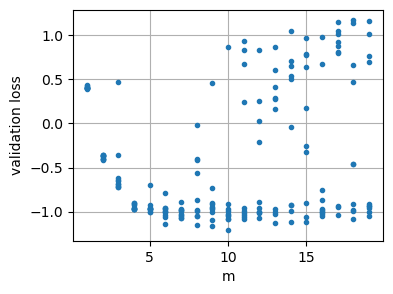

In [11]:
x=np.array([s['m'] for s in trained_rnn_parameters_list])
y=np.array([s['validation_loss'] for s in trained_rnn_parameters_list])
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(1,1,1)
ax.plot(x,y,'.')
ax.set_ylabel('validation loss')
ax.set_xlabel('m')
ax.grid(True)

Note that not all training attemps were successful, as usual in NN models. Therefore, typically many rounds and adjustments of fitting options are needed.

In [12]:
# sort the list according in ascending order of the validation_loss
trained_rnn_parameters_list=sorted(trained_rnn_parameters_list,key=lambda x: x['validation_loss']) 

# the 1st member of the list is the most optimal model
opt=trained_rnn_parameters_list[0]

#print it
for key in ['m','training_loss','validation_loss']: print(key,'=',opt[key],end=', ')

m = 10, training_loss = -0.9820279072512744, validation_loss = -1.2103918106651617, 

### **5. Make predictions, evaluate model performance**

Create a model instance with the optimal parameters

In [13]:
model=srnn.StochasticRNN(dim_in=opt['dim_in'],dim_out=opt['dim_out'],m=opt['m'])
model.load_state_dict(opt['weights'])

<All keys matched successfully>

To make SRNN predictions, we can just use the forward pass or predict function of StochasticRNN model. But we need to prepare inputs (with the same lag) at each time step. Here's an example of the function which predicts the next time steps of the data.

In [14]:
def predict_time_series(data: torch.Tensor, time: torch.Tensor, forcing: torch.Tensor,
                        lag: int, model: srnn.StochasticRNN, n_steps: int):
    '''
    The function to predict the time series ensemble (data), starting from its last time point

    Arguments: 
    data[N,NT,D]  -- normalized time series of the duration nt
    time[N,>=NT+n_steps-1,:] or [>=NT+n_steps-1,:]-- normalized time, synchronized with the data
    forcing[N,>=NT+n_steps-1,:] or [>=NT+n_steps-1,:]-- normalized forcing, synchronized with the data
    lag -- int, the lag to use (in this case must be the same used for model training)
    model -- StochasticRNN class
    n_steps>=0 -- int, number of prediction steps (lead time)
    
    Returns:
    
    tf tensors:
    
    data_prediction[N,n_steps+1,D] -- the last value of data + n_steps predicted values
    '''
    with torch.no_grad():
        N,NT,D=data.size()
        for i in range(n_steps):
            inputs=torch.cat([data[:,-lag:,:],
                            time[...,NT-lag+i:NT+i,:].expand(N,-1,-1),
                            forcing[...,NT-lag+i:NT+i,:].expand(N,-1,-1)],
                            dim=-1)
            data_next=model.predict(inputs)
            data=torch.cat([data,data_next],dim=-2)
        return data[...,NT-1:NT+n_steps,:].numpy()


Below we use this function to draw stochastic predictions of the evaluation data from one point and compare with actual trajectory (referred to as "observation")

(30, 201, 2)


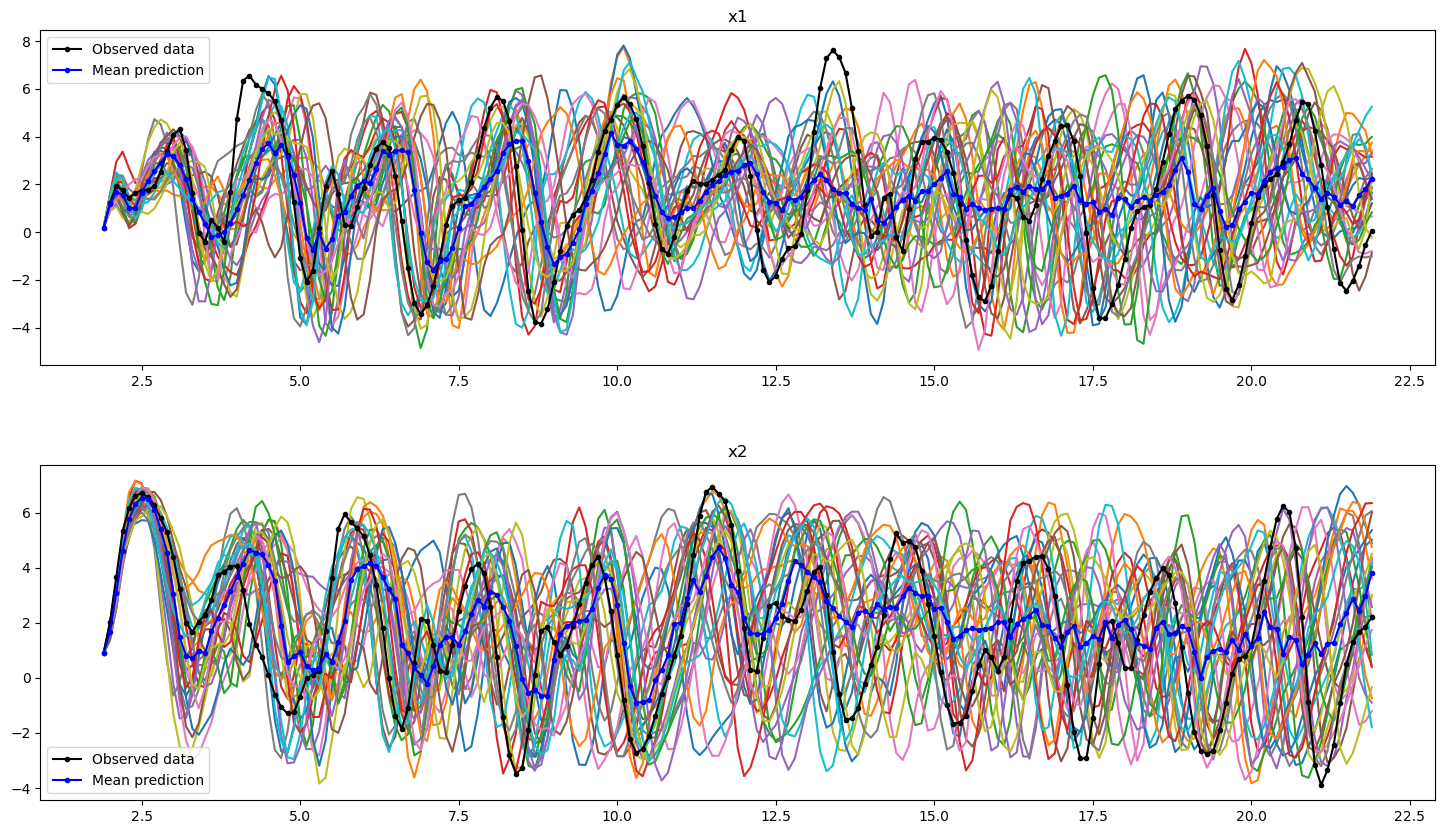

In [15]:
nstart=20   # starting point in time
N=30        # number of random realizations
n_steps=200 # lead time

# Normalize the evaluation data
evaluation_data=data_scaler.transform(raw_evaluation_data)
evaluation_data=torch.Tensor(evaluation_data)

#make prediction
predicted_ts=predict_time_series(evaluation_data[:nstart,:].expand(N,-1,-1),time,forcing,opt['lag'],model,n_steps=n_steps)
print(predicted_ts.shape)

#de-normalize
predicted_ts=data_scaler.inverse_transform(predicted_ts.reshape((N*(n_steps+1),-1))).reshape((N,n_steps+1,-1))

# compare with observations
observed_ts=raw_evaluation_data[nstart-1:nstart+n_steps,:]
t=raw_time[nstart-1:nstart+n_steps,0]

fig=plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.3)
for i in range(2):
    ax=fig.add_subplot(2,1,i+1)
    ax.set_title('x%d'%(i+1))
    #ax.fill_between(t,np.percentile(predicted_ts[...,i], 5, axis=0), np.percentile(predicted_ts[...,i], 95, axis=0), color='blue', alpha=0.5)
    ax.plot(t,predicted_ts[...,i].T,'-')
    ax.plot(t,observed_ts[:,i],'.-k',label='Observed data')
    ax.plot(t,np.median(predicted_ts[...,i],axis=0),'.-',color='blue',label='Mean prediction')
    ax.legend()
plt.show()    
plt.close(fig)

Here we plot the prediction root-mean-square errors of RNN. We do the same predictions as above, but many times: with train and evaluation datasets, and with many starting points. We don't de-normalize the predictions, so that the results have the normalized units, showing RMSE divided by the standard deviation of the data.

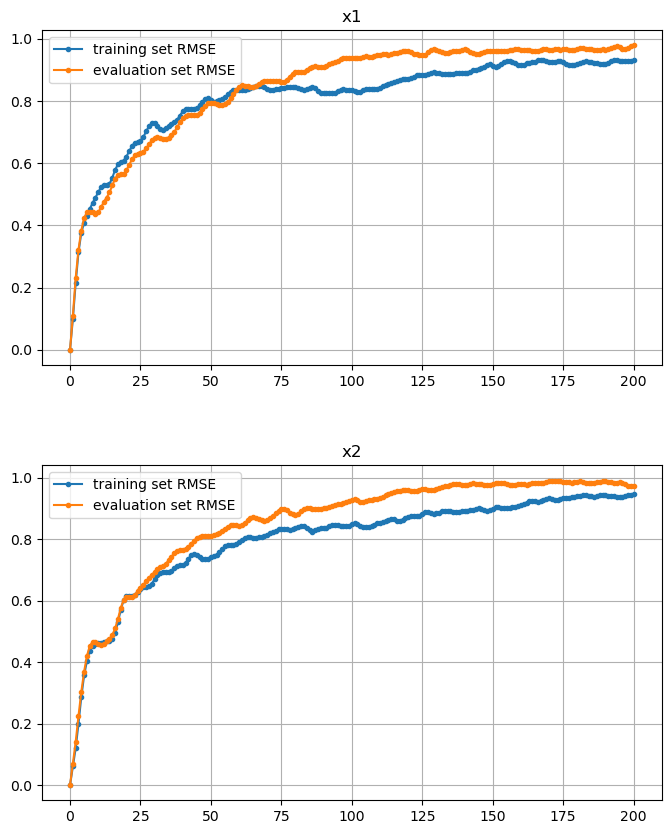

In [16]:
n_steps=200
nstart_values=list(range(opt['lag'],1000-n_steps))
N=100

errors=[]
for nstart in nstart_values:
    predicted_ts=predict_time_series(evaluation_data[:nstart,:].expand(N,-1,-1),time,forcing,opt['lag'],model,n_steps=n_steps)
    predictions=predicted_ts.mean(axis=0)
    observations=evaluation_data[nstart-1:nstart+n_steps,:].numpy()
    errors.append(predictions-observations)
evaluation_data_mse=(np.stack(errors,axis=0)**2).mean(axis=0)

errors=[]
for nstart in nstart_values:
    predicted_ts=predict_time_series(training_data[:nstart,:].expand(N,-1,-1),time,forcing,opt['lag'],model,n_steps=n_steps)
    predictions=predicted_ts.mean(axis=0)
    observations=training_data[nstart-1:nstart+n_steps,:].numpy()
    errors.append(predictions-observations)
training_data_mse=(np.stack(errors,axis=0)**2).mean(axis=0)

fig=plt.figure(figsize=(8,10))
fig.subplots_adjust(hspace=0.3)
for i in range(2):
    ax=fig.add_subplot(2,1,i+1)
    ax.set_title('x%d'%(i+1))
    ax.plot(np.sqrt(training_data_mse[:,i]),'.-',label='training set RMSE')
    ax.plot(np.sqrt(evaluation_data_mse[:,i]),'.-',label='evaluation set RMSE')
    ax.legend()
    ax.grid(True)
plt.show()    
plt.close(fig) 